In [1]:
#standard Data Science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import OrderedDict

#import gensim stuff
from gensim import corpora, models, similarities, matutils
#import sklearn utilities
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

#yellowbrick visualization
from yellowbrick.features import Rank2D
from yellowbrick.regressor import ResidualsPlot

#import regression algorithms
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from sklearn.linear_model import Lasso, LassoCV, Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     KFold, GridSearchCV)
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import scipy.stats as stats
import xgboost as xgb

#NLP imports
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

#other
import logging
import string
import nltk
nltk.download('punkt')

%matplotlib inline
sns.set()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anagiraldo-w/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#patents_abstracts=pd.read_csv(r'/Users/anagiraldo-w/ds/metis/metisgh/Patents Data/patent_abstracts/patent_abstracts.csv')
patents_abstract_sub=pd.read_csv(r'/Users/anagiraldo-w/ds/metis/metisgh/Patents Data/patent_abstracts/patent_abstract_sample.csv')
patents_abstract_sub.head()

,id,type,number,country,date,abstract,title,kind,num_claims,filename
0,7545023,utility,7545023,US,2009-06-09,A semiconductor transistor includes a substrat...,Semiconductor transistor,B2,10,ipg090609.xml
1,7819748,utility,7819748,US,2010-10-26,A display section <b>12</b> covered with a tou...,Game apparatus and storage medium storing game...,B2,14,ipg101026.xml
2,8104290,utility,8104290,US,2012-01-31,The present invention are directed towards a s...,Combustion liner damper,B2,5,ipg120131.xml
3,5865182,utility,5865182,US,1999-02-02,An improved viewing device which includes an ...,Positionable viewing shield with disposable tr...,A,11,pftaps19990202_wk05.zip
4,D750715,design,D750715,US,2016-03-01,NaN,Stationary bike,S1,1,ipg160301.xml


In [3]:
patents_abstract_sub['date'] = pd.to_datetime(patents_abstract_sub['date'])
patents_abstract_sub = patents_abstract_sub.sort_values(by='date')
patents_abstract_sub.head()

,id,type,number,country,date,abstract,title,kind,num_claims,filename
31021,3931068,utility,3931068,US,1976-01-06,Blends comprising biodegradable thermoplastic...,Blends of biodegradable thermoplastic oxyalkan...,A,28,pftaps19760106_wk01.zip
113488,3930762,utility,3930762,US,1976-01-06,A gas compressor or blower comprising a cylin...,Apparatus for use as a gas compressor or gas b...,A,3,pftaps19760106_wk01.zip
161404,3930973,utility,3930973,US,1976-01-06,"A method and apparatus for electrophoresis, c...",Electrophoretic process,A,4,pftaps19760106_wk01.zip
61566,3930478,utility,3930478,US,1976-01-06,An exhaust gas-detoxicating system for an ext...,System for the detoxication of exhaust gases,A,10,pftaps19760106_wk01.zip
36194,3931539,utility,3931539,US,1976-01-06,A superorthicon-type television camera tube w...,Superorthicon-type television camera tube havi...,A,8,pftaps19760106_wk01.zip


In [4]:
patents_abstract_sub.isnull().sum()

id                0
type              0
number            0
country           0
date              0
abstract      18101
title             6
kind              0
num_claims        0
filename          0
dtype: int64

In [5]:
patents_abstract_sub = patents_abstract_sub.dropna(how='any')

In [6]:
abstracts = patents_abstract_sub['abstract']

In [7]:
patents_abstract_sub.isnull().sum()

id            0
type          0
number        0
country       0
date          0
abstract      0
title         0
kind          0
num_claims    0
filename      0
dtype: int64

### Natural Language Processing ###

In [8]:
additional_stops = ['http', 'www', 'br', 'gp', 'com', 'href', 've', 'don', 'product', 'bit', '10', 'ch', 'al', 'nh', 'invention', 'relates', 'str1', 'sup', 'sub', 'represents', 'relates', 'novel', 'useful', 'general', 'provides', 'first', 'second', 'r', 'rsup', 'rsub', 'b', 'bb']
stop_words = ENGLISH_STOP_WORDS.union(additional_stops)

In [9]:
def custom_tokenizer(text):

    # remove punctuation
    remove_punct = str.maketrans('', '', string.punctuation)
    text = text.translate(remove_punct)

    # remove digits and convert to lower case
    remove_digits = str.maketrans('', '', string.digits)
    text = text.lower().translate(remove_digits)

    # tokenize
    tokens = word_tokenize(text)

    # remove stop words
    tokens_stop = [y for y in tokens if y not in stop_words]

    # stem
    stemmer = SnowballStemmer('english')
    tokens_stem = [stemmer.stem(y) for y in tokens_stop] 
    
#     # lemmatize
#     lemmatizer = WordNetLemmatizer()

    return tokens_stem


In [10]:
tfidf = TfidfVectorizer(ngram_range=(1, 1),
                        analyzer='word',
                        tokenizer=custom_tokenizer,
                        strip_accents='unicode',
                        max_df=0.05
                       )

In [12]:
tfidf_vec = tfidf.fit_transform(abstracts)
tfidf_vec.shape

(181893, 121488)

In [ ]:
# vec = CountVectorizer(ngram_range=(1, 2),
#                       analyzer='word',
#                       stop_words=stop_words,
#                       strip_accents='unicode',
#                       max_df=0.11
#                      )
# vec.fit(abstracts)

# counts_vec = vec.transform(abstracts).transpose()

In [13]:
nmf = NMF(100)
abstract_vecs = nmf.fit_transform(tfidf_vec)

In [14]:
abstract_features = tfidf.get_feature_names()
abstract_topics = [[abstract_features[idx] for idx in np.flip(np.argsort(component)[-20:], axis=0)] for component in nmf.components_]

In [15]:
topic_names = [[abstract_features[idx] for idx in np.flip(np.argsort(component)[-2:], axis=0)] for component in nmf.components_]

In [16]:
def print_topics(topics):
    for i,topic in enumerate(topics):
        print("Topic {}".format(i))
        print(", ".join(topic)+"\n")

In [17]:
def topic_dataframe(topics):
        df_topics = [", ".join(topic) for i,topic in enumerate(topics)]
        df_topics = pd.DataFrame(df_topics, columns=['topics'])
        df_topics['topic'] = df_topics.index
        return df_topics

In [18]:
df_topic = topic_dataframe(topic_names)
df_topic.head()

,topics,topic
0,"clamp, upper",0
1,"insul, conductor",1
2,"network, wireless",2
3,"compound, pharmaceut",3
4,"voltag, refer",4


In [19]:
print_topics(abstract_topics)

Topic 0
clamp, upper, hole, secur, fasten, rod, thread, insert, spring, pair, pin, leg, elong, slot, bar, adjust, screw, project, sleev, longitudin

Topic 1
insul, conductor, hole, interlay, gate, trench, expos, plug, shield, cabl, ground, etch, upper, interconnect, isol, sidewal, thermal, surround, fill, spacer

Topic 2
network, wireless, servic, access, messag, request, server, protocol, client, address, manag, traffic, interfac, rout, subscrib, link, local, gateway, secur, identifi

Topic 3
compound, pharmaceut, prepar, treatment, diseas, treat, organ, agent, disord, accept, describ, inhibit, salt, inhibitor, catalyst, receptor, intermedi, condit, therapeut, administ

Topic 4
voltag, refer, level, capacitor, regul, convert, compar, dc, transistor, threshold, ac, low, bias, charg, rectifi, puls, invert, driver, ground, resistor

Topic 5
optic, waveguid, reflect, wavelength, path, illumin, axi, emit, polar, refract, project, disc, index, detector, diffract, mirror, grate, plane, disk,

### Add Topics and Other Data to DataFrame ###

In [20]:
df = pd.DataFrame([])
df['topic']=[abstract_vec.argmax() for abstract_vec in abstract_vecs]
df['topic'].value_counts()

98    9582
87    8165
3     4709
93    4502
56    4473
99    4048
14    3562
89    3425
94    3399
92    3322
7     3302
20    3086
48    2864
88    2744
11    2691
85    2650
42    2612
76    2575
97    2563
69    2549
96    2482
59    2354
86    2351
5     2239
58    2234
80    2163
46    2152
90    2139
38    2125
73    2077
      ... 
23    1004
31    1004
12    1002
51     986
9      968
79     966
22     961
2      961
44     936
72     932
25     924
36     919
1      891
47     887
37     882
29     863
60     811
50     742
35     669
39     635
32     586
34     548
17     494
4      463
16     389
6      292
15     253
26     211
21     143
0        5
Name: topic, Length: 100, dtype: int64

In [21]:
df_patents = patents_abstract_sub.merge(df, on=df.index)
df_patents = df_patents.merge(df_topic, on='topic')
df_patents = df_patents.drop(['filename', 'key_0'], axis=1)
del df
df_patents.head(2)

,id,type,number,country,date,abstract,title,kind,num_claims,topic,topics
0,3931068,utility,3931068,US,1976-01-06,Blends comprising biodegradable thermoplastic...,Blends of biodegradable thermoplastic oxyalkan...,A,28,98,"coat, polym"
1,3931224,utility,3931224,US,1976-01-06,New curable monomeric aromatic imidodicarboxy...,Aromatic imidodicarboxylic acid diallyl esters...,A,3,98,"coat, polym"


In [22]:
df_patent_values = pd.read_csv('patents.csv')
#df_cites = pd.read_csv('cites.csv')

/Users/anagiraldo-w/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
df_patent_values['number'] = df_patent_values['patnum']
df_patent_values = df_patent_values.drop('patnum', axis=1)
df_patent_values.head(2)

,fdate,idate,pdate,permno,class,subclass,ncites,xi,number
0,4/14/1919,1/5/1926,NaN,NaN,NaN,NaN,NaN,NaN,1568040
1,8/21/1923,1/5/1926,NaN,NaN,NaN,NaN,NaN,NaN,1568041


In [24]:
df_patent_values['number'] = df_patent_values['number'].astype('str')
df_patent_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6240106 entries, 0 to 6240105
Data columns (total 9 columns):
fdate       object
idate       object
pdate       object
permno      float64
class       object
subclass    object
ncites      float64
xi          float64
number      object
dtypes: float64(3), object(6)
memory usage: 428.5+ MB


In [25]:
df_patents = df_patents.merge(df_patent_values, how='left', on='number')
del df_patent_values
df_patents.head(2)

,id,type,number,country,date,abstract,title,kind,num_claims,topic,topics,fdate,idate,pdate,permno,class,subclass,ncites,xi
0,3931068,utility,3931068,US,1976-01-06,Blends comprising biodegradable thermoplastic...,Blends of biodegradable thermoplastic oxyalkan...,A,28,98,"coat, polym",7/15/1974,1/6/1976,NaN,15659.0,524,014000O,32.0,5.21714
1,3931224,utility,3931224,US,1976-01-06,New curable monomeric aromatic imidodicarboxy...,Aromatic imidodicarboxylic acid diallyl esters...,A,3,98,"coat, polym",9/4/1973,1/6/1976,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df_patents.isnull().sum()

id                 0
type               0
number             0
country            0
date               0
abstract           0
title              0
kind               0
num_claims         0
topic              0
topics             0
fdate          60514
idate          60513
pdate         147761
permno        137824
class         141091
subclass      141091
ncites        141074
xi            141074
dtype: int64

In [ ]:
df_patents.shape

In [ ]:
min(df_patents.xi)

In [ ]:
df_location_assignee = pd.read_csv('location_assignee.csv')
df_location = pd.read_csv('location.csv')

In [ ]:
df_location = df_location.rename({'id': 'location_id'}, axis=1)
df_location_assignee = df_location_assignee.merge(df_location, how='left', on='location_id')
del df_location
df_location_assignee.head()

In [ ]:
df_assignee = pd.read_csv('assignee.csv')
df_assignee = df_assignee.rename({'id':'assignee_id'}, axis=1)
df_assignee = df_assignee.merge(df_location_assignee, on='assignee_id', how ='left')
del df_location_assignee
df_assignee.head()

In [ ]:
df_patent_assignee = pd.read_csv('patent_assignee.csv')
df_patent_assignee = df_patent_assignee.rename({'patent_id':'number'}, axis='columns')
df_patent_assignee = df_patent_assignee.merge(df_assignee, on='assignee_id', how='left')
del df_assignee
df_patent_assignee = df_patent_assignee.dropna()
df_patent_trim = df_patents.merge(df_patent_assignee, on='number', how='left')
del df_patent_assignee
df_patent_trim.head()

In [ ]:
df_patent_trim.isnull().sum()

In [ ]:
df_patent_assignee = df_patent_assignee.drop(['assignee_id', 'name_first', 'name_last', 'location_id', 'city', 'state', 'county', 'state_fips', 'county_fips'], axis=1)
df_patent_assignee = df_patent_assignee.dropna()
df_patent_assignee.head()

In [ ]:
df_patents_trim = df_patents.merge(df_govt, how='left', on='number')
del df_govt
df_patents_trim = df_patents_trim.merge(df_assignee, how='left', on='number')
del df_assignee
df_patents_trim.to_csv('patents_trim')
df_patents_trim.head(20)

In [ ]:
df_govt = pd.read_csv('govt.csv')
df_govt['gi'] = 1
df_govt = df_govt.rename({'patent_id': 'number'}, axis='columns')
df_govt = df_govt.drop('gi_statement', axis=1)
df_govt.head()

In [ ]:

df_patents.head(20)

In [ ]:
df_patents.isnull().sum()

In [ ]:
df_patents

In [27]:
df_patents = df_patents.dropna()
df_patents.isnull().sum()

id            0
type          0
number        0
country       0
date          0
abstract      0
title         0
kind          0
num_claims    0
topic         0
topics        0
fdate         0
idate         0
pdate         0
permno        0
class         0
subclass      0
ncites        0
xi            0
dtype: int64

In [28]:
len(df_patents['xi'])

13218

In [29]:
max(df_patents['ncites'])

225.0

In [30]:
df_patents['sqrt_ncites'] = np.sqrt(df_patents['ncites'])
df_patents['sqrt_claims'] = np.sqrt(df_patents['num_claims'])
df_patents['xi'] = np.log(df_patents['xi'])
df_patents.head(2)

,id,type,number,country,date,abstract,title,kind,num_claims,topic,...,fdate,idate,pdate,permno,class,subclass,ncites,xi,sqrt_ncites,sqrt_claims
5420,6329227,utility,6329227,US,2001-12-11,An organic polymer film patterning method inc...,Method of patterning organic polymer film and ...,A,15,98,...,2/22/2001,12/11/2001,8/30/2001,53727.0,438,151000O,1.0,-2.251015,1.0,3.872983
5468,6355757,utility,6355757,US,2002-03-12,The invention is directed to essentially satur...,Processing olefin copolymers,B2,11,98,...,2/6/1998,3/12/2002,1/24/2002,11850.0,526,348000O,0.0,4.729758,0.0,3.316625


In [31]:
df_patents['year'] = df_patents['date'].dt.year
df_patents.head(2)

,id,type,number,country,date,abstract,title,kind,num_claims,topic,...,idate,pdate,permno,class,subclass,ncites,xi,sqrt_ncites,sqrt_claims,year
5420,6329227,utility,6329227,US,2001-12-11,An organic polymer film patterning method inc...,Method of patterning organic polymer film and ...,A,15,98,...,12/11/2001,8/30/2001,53727.0,438,151000O,1.0,-2.251015,1.0,3.872983,2001
5468,6355757,utility,6355757,US,2002-03-12,The invention is directed to essentially satur...,Processing olefin copolymers,B2,11,98,...,3/12/2002,1/24/2002,11850.0,526,348000O,0.0,4.729758,0.0,3.316625,2002


In [32]:
df_patents = df_patents.replace([np.inf, -np.inf], 0)

(array([9.214e+03, 2.777e+03, 8.830e+02, 2.070e+02, 8.800e+01, 2.500e+01,
        1.700e+01, 6.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <a list of 10 Patch objects>)

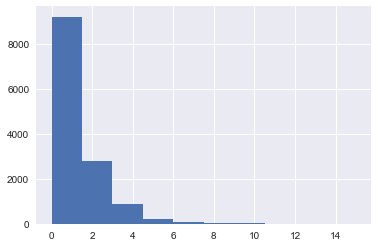

In [35]:
plt.hist(df_patents['sqrt_ncites'])

In [36]:
min(df_patents.date)

Timestamp('2001-08-07 00:00:00')

In [37]:
df_patents['days_since'] = (df_patents['date'] - pd.to_datetime('2001-08-07') ).astype('timedelta64[D]')
df_patents = df_patents.drop('date', axis=1)
df_patents.days_since = df_patents.days_since.astype('int64')
df_patents.head()

,id,type,number,country,abstract,title,kind,num_claims,topic,topics,...,pdate,permno,class,subclass,ncites,xi,sqrt_ncites,sqrt_claims,year,days_since
5420,6329227,utility,6329227,US,An organic polymer film patterning method inc...,Method of patterning organic polymer film and ...,A,15,98,"coat, polym",...,8/30/2001,53727.0,438.0,151000O,1.0,-2.251015,1.000000,3.872983,2001,126
5468,6355757,utility,6355757,US,The invention is directed to essentially satur...,Processing olefin copolymers,B2,11,98,"coat, polym",...,1/24/2002,11850.0,526.0,348000O,0.0,4.729758,0.000000,3.316625,2002,217
5485,6365650,utility,6365650,US,An adhesive suitable for bonding wood is both ...,Heat and radio frequency-curable two-pack soy ...,B1,12,98,"coat, polym",...,3/14/2002,24272.0,524.0,026000O,7.0,1.725626,2.645751,3.464102,2002,238
5542,6399088,utility,6399088,US,This invention provides water-based compositio...,Citric acid tri-alkylamide surfactants,B1,14,98,"coat, polym",...,4/11/2002,28222.0,424.0,405000O,0.0,1.862359,0.000000,3.741657,2002,301
5575,6417281,utility,6417281,US,The invention is directed to essentially satur...,Processing olefin copolymers,B1,12,98,"coat, polym",...,4/25/2002,11850.0,525.0,240000O,0.0,4.882032,0.000000,3.464102,2002,336


In [38]:
df_patents['topic'] = df_patents['topic'].astype('category')

In [60]:
patent_values = df_patents['xi']

df_patents_smaller = df_patents.loc[:,['days_since', 'year', 'num_claims', 'sqrt_claims', 'topics', 'ncites', 'sqrt_ncites', 'xi']]
x_patents = df_patents.loc[:,['number', 'days_since', 'year', 'num_claims', 'sqrt_claims', 'topics', 'ncites', 'sqrt_ncites']]

In [61]:
df_patents_smaller.to_csv('patent_summary.csv')

In [62]:
df_patents.to_csv('df_patents.csv')

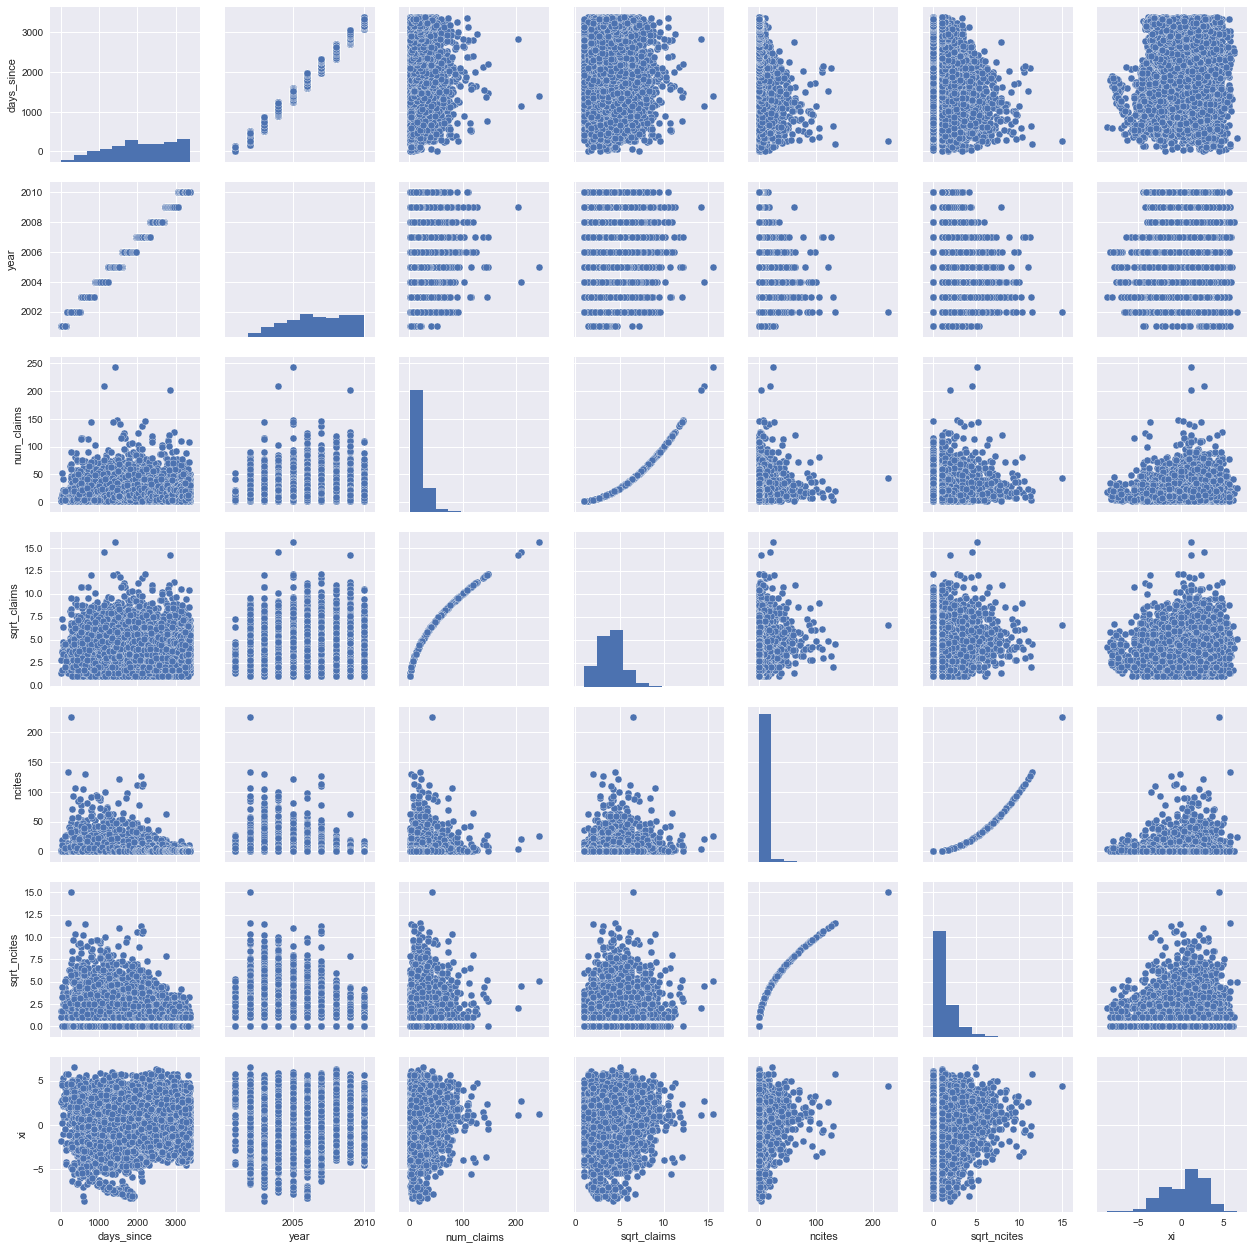

In [63]:
sns.pairplot(df_patents_smaller)

/Users/anagiraldo-w/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


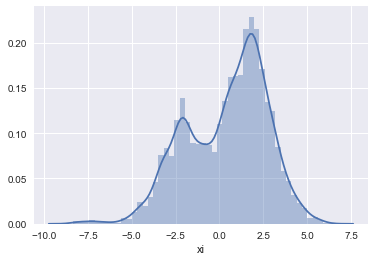

In [64]:
sns.distplot(patent_values)

In [65]:
len(df_patents['xi'])

13218

In [66]:
df_patents.topic = df_patents.topic.astype('str')

### Baseline ###

In [67]:
x_base, x_test_base, y_base, y_test_base = train_test_split(x_patents, patent_values)

In [68]:
x_baseline = x_base.loc[:,['ncites']]
x_test_baseline = x_test_base.loc[:,['ncites']]

In [69]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

In [74]:
model = sm.OLS(y_base,sm.add_constant(x_base))
results = model.fit()
y_pred = results.predict(sm.add_constant(x_test_base))
results.summary()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [75]:
type(y_pred)

NameError: name 'y_pred' is not defined

In [76]:
def single_regression_plot(x, y, y_pred):
    plt.figure(figsize=(20,5))

    plt.subplot(1, 3, 1)
    plt.scatter(x, y)
    plt.plot(x, y_pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - y_pred
    plt.scatter(y_pred, res, alpha=0.2)
    plt.plot(np.linspace(-2,6,1000), np.linspace(0,0,1000))
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

In [77]:
single_regression_plot(x_test_baseline, y_test, y_pred)

NameError: name 'y_test' is not defined

### Multiple Regression ##

In [95]:
from sklearn.metrics import mean_squared_error
def RMSE(actual, predicted):
    return np.sqrt(mean_squared_error(actual,predicted)) 

In [96]:
def rmse(actuals, preds):
    return np.sqrt(((actuals - preds) ** 2).mean())

In [97]:
alphavec = 10**np.linspace(-3,9,27)
steps = [('polynomial', PolynomialFeatures()), ('standardize', StandardScaler())]
pipe = Pipeline(steps)

In [98]:
selected = ['days_since', 'year', 'num_claims', 'topics', 'sqrt_ncites']

In [99]:
x2 = pd.get_dummies(df_patents.loc[:,selected])
x2.head()

,days_since,year,num_claims,sqrt_ncites,"topics_acid, nucleic","topics_air, cool","topics_amplifi, stage","topics_antenna, radiat","topics_arm, pivot","topics_batteri, charg",...,"topics_tube, cathet","topics_user, content","topics_valv, close","topics_vehicl, steer","topics_video, digit","topics_voltag, refer","topics_wall, edg","topics_water, pipe","topics_wheel, brake","topics_wire, coil"
5420,126,2001,15,1.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5468,217,2002,11,0.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5485,238,2002,12,2.645751,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5542,301,2002,14,0.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5575,336,2002,12,0.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
x2_train, x2_test, y, y_test = train_test_split(x2, patent_values)

In [101]:
pipe.fit_transform(x2_train)
lm1 = LassoCV(alphas=alphavec, cv=kfold)
lm1.fit(x2_train, y)
y_pred = lm1.predict(x2_test)
scores = cross_val_score(lm1, x2_test, y_test, cv=kfold, scoring='mean_squared_error')
print('Multiple Linear regression val R^2: %.3f' 
      % lm1.score(x2_test, y_test))
print('Multiple Linear regression score val RMSE: %.3f' 
      % RMSE(lm1.predict(x2_test), y_test))
print(-scores)
print('Best Alpha: %.3f' 
      % lm1.alpha_)

/Users/anagiraldo-w/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/anagiraldo-w/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/anagiraldo-w/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/anagiraldo-w/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  s

Multiple Linear regression val R^2: 0.111
Multiple Linear regression score val RMSE: 2.200
[4.67724203 5.06599658 4.94199248 5.12373045 4.71528866]
Best Alpha: 0.001


/Users/anagiraldo-w/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


In [102]:
def multiple_regression_plot(x, y, y_pred):
    plt.figure(figsize=(20,5))

    plt.subplot(1, 3, 2)
    res = y - y_pred
    plt.scatter(y_pred, res, alpha=0.2)
    plt.plot(np.linspace(-2,4,1000), np.linspace(0,0,1000))
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

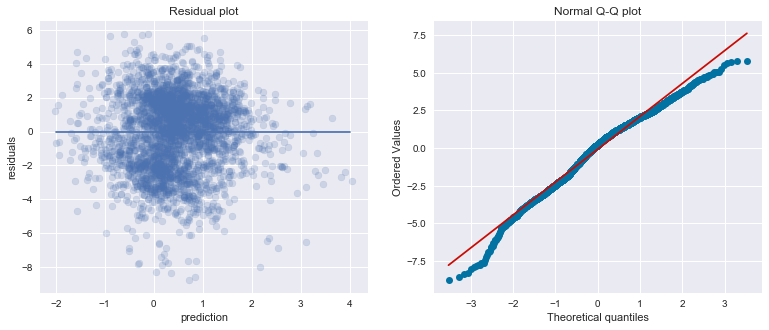

In [103]:
multiple_regression_plot(x2_test, y_test, y_pred)

<bound method Visualizer.poof of ResidualsPlot(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x1c3b02c6d8>,
       hist=True, line_color=None, model=None, test_color=None,
       train_color=None)>

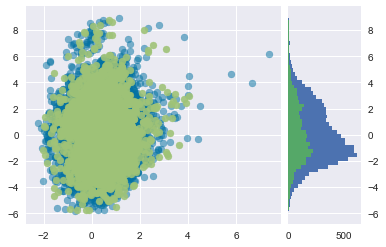

<Figure size 1080x504 with 0 Axes>

In [104]:
visualizer = ResidualsPlot(lm1, line_color='#111111')
visualizer.fit(x2_train, y)
visualizer.score(x2_test, y_test)
plt.figure(figsize = (15,7))
visualizer.poof

### Random Forest ###

In [105]:
# parameters = {'n_estimators':[10], 'max_features':range(1,107), 'max_depth':range(1,15), 'n_jobs':[-1]}
# rf1 = RandomForestRegressor()
# grid = GridSearchCV(rf1, parameters)
#y_pred = rf1.predict(x2_test)

In [106]:
rf1 = RandomForestRegressor(n_estimators=100, max_features = 17, max_depth = 11, n_jobs = -1)

R-Squared: 0.110710


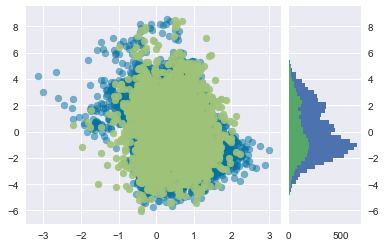

<Figure size 864x504 with 0 Axes>

In [107]:
visualizer = ResidualsPlot(rf1, line_color='#111111')
visualizer.fit(x2_train, y)
visualizer.score(x2_test, y_test)
plt.figure(figsize = (12,7))
visualizer.poof
print('R-Squared: %3f' %rf1.score(x2_test,y_test))

In [108]:
rf1.fit(x2_train, y)
y_pred = rf1.predict(x2_test)
scores = cross_val_score(rf1, x2_test, y_test, cv=kfold, scoring='mean_squared_error')
print('Multiple Linear regression val R^2: %.3f' 
      % rf1.score(x2_test, y_test))
print('Multiple Linear regression score val RMSE: %.3f' 
      % rmse(rf1.predict(x2_test), y_test))
print(-scores)

/Users/anagiraldo-w/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/anagiraldo-w/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/anagiraldo-w/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/anagiraldo-w/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  s

Multiple Linear regression val R^2: 0.113
Multiple Linear regression score val RMSE: 2.197
[4.82211725 5.11490416 5.13222772 5.01909105 4.75457449]


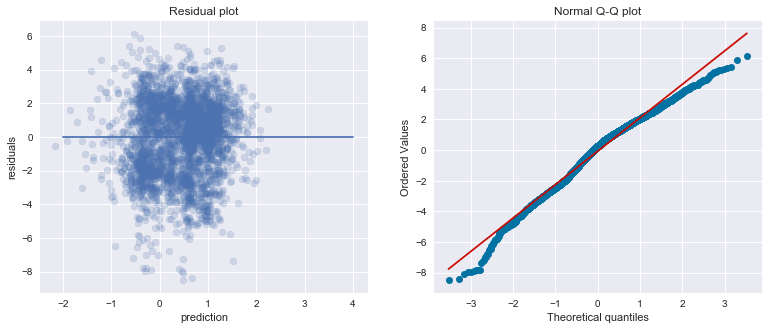

In [109]:
multiple_regression_plot(x2_test, y_test, y_pred)

In [110]:
sorted(zip(x2_train.columns,abs(rf1.feature_importances_)), key=lambda x: -x[1])

[('num_claims', 0.36413270580731316),
 ('days_since', 0.187252704353002),
 ('sqrt_ncites', 0.07918834453013403),
 ('year', 0.07495253407384307),
 ('topics_compound, pharmaceut', 0.03743937498174878),
 ('topics_record, medium', 0.03057690742197485),
 ('topics_comput, applic', 0.02947157298700959),
 ('topics_acid, nucleic', 0.02122292448291815),
 ('topics_coat, polym', 0.017756072896913676),
 ('topics_electrod, capacitor', 0.011155907309065597),
 ('topics_semiconductor, wafer', 0.008977858040624433),
 ('topics_liquid, crystal', 0.008436614689708211),
 ('topics_tool, machin', 0.007990343126444114),
 ('topics_display, screen', 0.0072982400859739815),
 ('topics_fluid, pump', 0.006904157733997019),
 ('topics_pixel, array', 0.005420593429288762),
 ('topics_len, focus', 0.004710594893111968),
 ('topics_roller, belt', 0.004275795773640481),
 ('topics_insul, conductor', 0.004262981144170947),
 ('topics_plate, face', 0.004120198606587194),
 ('topics_optic, waveguid', 0.003986799405075605),
 ('top

### XGBoost ###

In [ ]:
gbm = xgb.XGBRegressor( 
                       n_estimators=30000, #arbitrary large number
                       n_jobs=3,
                       max_depth=3,
                       objective="reg:linear",
                       learning_rate=.05, 
                       subsample=.6,
                       min_child_weight=12,
                       colsample_bytree=.8,
                      )

eval_set=[(x2_train,y),(x2_test,y_test)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    x2_train, y, 
                    eval_set=eval_set,
                    eval_metric='rmse',
                    early_stopping_rounds=50,
                    verbose=False
                   )
y_pred = gbm.predict(x2_test, ntree_limit=gbm.best_ntree_limit)

print(rmse(gbm.predict(x2_test, ntree_limit=gbm.best_ntree_limit),y_test))
print(r2_score(y_test, y_pred))

In [ ]:
# visualizer2 = ResidualsPlot(gbm, line_color='#111111')
# visualizer2.fit(x2_train, y, eval_set=eval_set, eval_metric='rmse', early_stopping_rounds=50, verbose=False )
# visualizer2.score(x2_test, y_test                        )
# plt.figure(figsize = (12,7))
# visualizer2.poof

In [ ]:
multiple_regression_plot(x2_test, y_test, y_pred)

### LDA ###

In [ ]:
# cv_corpus = matutils.Sparse2Corpus(counts_vec)
# id2word = dict((v, k) for k, v in vec.vocabulary_.items())
# lda = models.LdaModel(corpus=cv_corpus, num_topics=20, id2word=id2word, passes=10)
# lda.print_topics()